In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Create dataset of masked rasters

**Input:** 

Raw data 
* .SAFE JP2 
* .shp  files

**Output:**

Two types of masks:

1. Original data - just the farm, sliced out from the spectral bands
2. Original masks zero-padded to be the same size as the largest farm

Output Directory:

`data/interim/masks/{train/test}/{date}/{farm_id}/{band}.npy`

## Overview

Very similar to making baseline dataset, except that now the process stops at masking and the masked farms are output as `.npy` files.

In this notebook, we will write a prototype to load the data from one band in one timestamp and create masks for all the farms in the training set.


In [2]:
import os
import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

import sys
sys.path.append('../')
from config import interim_data_dir, raw_data_dir

from src.utils import get_img_bands, get_safe_dirs, date_from_safedir, band_from_imgpath, read_shapefile, mask_raster

In [3]:
dataset = 'train'

#  Setup directories
masks_dir = os.path.join(interim_data_dir, 'masks')

# train / test dir under masks
dataset_dir = os.path.join(masks_dir, dataset)

print('Creating {} feature dataset'.format(dataset))

print('Reading shapefile...')
shp_df = read_shapefile(dataset)

shp_df.head()

Creating train feature dataset
Reading shapefile...


,Area,Subregion,Crop_Id_Ne,geometry
Field_Id,,,,
1,0.915905,3,8,"POLYGON ((613924.3324000851 6793991.295069702,..."
2,2.064410,3,6,"POLYGON ((614404.0717397591 6794020.579634549,..."
3,1.080300,3,8,"POLYGON ((614320.2146632321 6793964.242091182,..."
4,1.316190,3,8,"POLYGON ((614560.5326844405 6794002.249461887,..."
7,5.529220,3,8,"POLYGON ((614596.6564746551 6794269.865436315,..."


### Read Image bands for one SAFE dump

In [4]:
safe_dirs = get_safe_dirs()

# Choose the first SAFE file
safe_dir = safe_dirs[0]

# Get the date of the data dump
date = date_from_safedir(safe_dir)

out_dir = os.path.join(dataset_dir, date)

print('Reading image bands...')
img_band_fpaths = get_img_bands(safe_dir)
print(f'Found {len(img_band_fpaths)} image bands to process')

Reading image bands...
Found 14 image bands to process


### Select one spectral band

In [5]:
img_fpath = img_band_fpaths[0]

band = band_from_imgpath(img_fpath)

# Getting masks for all farms in training set
print('Processing band ', band)
with rasterio.open(img_fpath) as raster:
    print('Masking raster...')
    masks = mask_raster(shp_df.geometry, raster, return_missing=dataset == 'test')

Processing band  B08
Masking raster...


### Select one farm to prototype zero padding

In [6]:
import gc
import operator
def get_largest_dims(masks_dict):
    """
    Get the largest width and height from all farms
    TODO: Make this better
    """
     # First find the largest farm
    dims = [mask.shape for mask in masks.values()]

    max_width = max([sh[0] for sh in dims])
    max_height = max([sh[-1] for sh in dims])
    
    del dims
    gc.collect()
    
    return max_width, max_height

max_width, max_height = get_largest_dims(masks)
print(f'Largest dims: {max_width, max_height}')

Largest dims: (90, 83)


Just make the max dims (100, 100)

In [7]:
max_dims=(100,100)

/Users/renier.botha/anaconda3/envs/farm-pin/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/Users/renier.botha/anaconda3/envs/farm-pin/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log10
/Users/renier.botha/anaconda3/envs/farm-pin/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10
/Users/renier.botha/anaconda3/envs/farm-pin/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log10


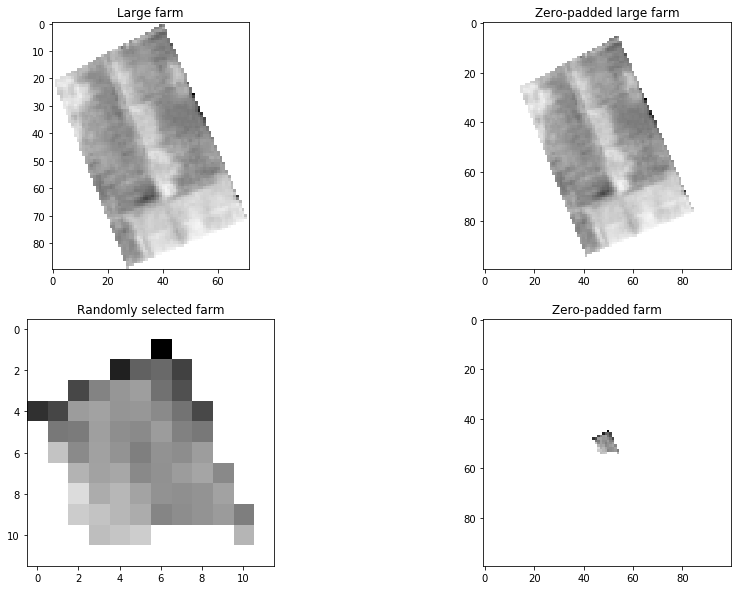

In [8]:
import cv2

def zeropad_img(img, shape):
    
#     print(img.shape, shape)

    # Size of border
    v_border = int(np.ceil((shape[0] - img.shape[0])/2))
    h_border = int(np.ceil((shape[1] - img.shape[1])/2))
    
#     print(v_border, h_border)
    
    v_diff = shape[0] - (img.shape[0] + 2*v_border)
    h_diff = shape[1] - (img.shape[1] + 2*h_border)
    
    new_img = cv2.copyMakeBorder(
        img, 
        top=v_border, bottom=v_border+v_diff, 
        left=h_border, right=h_border+h_diff,
        borderType=cv2.BORDER_CONSTANT, value=0
    )
    
#     print(new_img.shape)
    
    assert new_img.shape == (100, 100), 'zero padding issue'
    
    return new_img

np.random.seed(420)
fig, axes = plt.subplots(2, 2, figsize=(15,10))

# Plot farm with largest width
large_farm = [mask for mask in masks.values() if mask.shape[0] > 80][0]
ax=axes[0][0]
ax.imshow(np.log10(large_farm), cmap='gray')
ax.set_title('Large farm')

# Zero pad the large farm
ax=axes[0][1]
ax.imshow(np.log10(zeropad_img(large_farm, shape=max_dims)), cmap='gray')
ax.set_title('Zero-padded large farm')

# Pick a random farm to process
random_farm = np.random.choice(list(masks.keys()))
mask = masks[random_farm]
ax=axes[1][0]
ax.imshow(np.log10(mask), cmap='gray')
ax.set_title('Randomly selected farm')

# Zero pad random farm and show
zp_image = zeropad_img(mask, shape=max_dims)
ax = axes[1][1]
ax.imshow(np.log10(zp_image), cmap='gray')
ax.set_title('Zero-padded farm')
plt.show()

## Repeat zero pad for all images in one band

In [9]:
from tqdm import tqdm

max_dims=(100,100)

for img_fpath in tqdm(img_band_fpaths, desc='bands'):
    
    band = band_from_imgpath(img_fpath)

    with rasterio.open(img_fpath) as raster:
        masks = mask_raster(shp_df.geometry, raster, return_missing=dataset == 'test')

        # Create zeropadded masks
        zp_masks = {id: zeropad_img(mask, shape=max_dims) for id, mask in masks.items()}

    # Save masks for each farm
    for farm_id in masks.keys():
        mask = masks[farm_id]
        zp_mask = zp_masks[farm_id]
        
        farm_dir = os.path.join(out_dir, str(farm_id))
#         safe_create_dir(farm_dir)

        mask_fname = os.path.join(farm_dir, f'{band}.npy')
        zp_mask_fname = os.path.join(farm_dir, f'{band}_zp.npy')

        np.save(mask_fname, mask)
        np.save(zp_mask_fname, zp_mask)

    del masks
    del zp_masks
    gc.collect()

bands: 100%|██████████| 14/14 [00:54<00:00,  3.72s/it]


In [ ]:
import cv2

def zeropad_img(img, shape):

    # Size of border
    v_border = int(np.ceil((shape[0] - img.shape[0])/2))
    h_border = int(np.ceil((shape[1] - img.shape[1])/2))
    
    v_diff = shape[0] - (img.shape[0] + 2*v_border)
    h_diff = shape[1] - (img.shape[1] + 2*h_border)
    
    new_img = cv2.copyMakeBorder(
        img, 
        top=v_border, bottom=v_border, 
        left=h_border, right=h_border,
        borderType=cv2.BORDER_CONSTANT, value=0
    )
    
    
    
    assert new_img.shape == (100, 100), 'zero padding issue'
    
    return new_img

np.random.seed(420)
fig, axes = plt.subplots(2, 2, figsize=(15,10))

# Plot farm with largest width
large_farm = [mask for mask in masks.values() if mask.shape[0] > 80][0]
ax=axes[0][0]
ax.imshow(np.log10(large_farm), cmap='gray')
ax.set_title('Large farm')

# Zero pad the large farm
ax=axes[0][1]
ax.imshow(np.log10(zeropad_img(large_farm, shape=max_dims)), cmap='gray')
ax.set_title('Zero-padded large farm')

# Pick a random farm to process
random_farm = np.random.choice(list(masks.keys()))
mask = masks[random_farm]
ax=axes[1][0]
ax.imshow(np.log10(mask), cmap='gray')
ax.set_title('Randomly selected farm')

# Zero pad random farm and show
zp_image = zeropad_img(mask, shape=max_dims)
ax = axes[1][1]
ax.imshow(np.log10(zp_image), cmap='gray')
ax.set_title('Zero-padded farm')
plt.show()

## Check dirs by date

Check that each date has two directories (JEP and JFP)

In [17]:
dirs_by_date={}
for dir in safe_dirs:
    date = date_from_safedir(dir)
    if date not in dirs_by_date:
        dirs_by_date[date] = [dir]
    else:
        dirs_by_date[date].append(dir)
        
dirs_by_date

{'2017-07-10': ['/Users/renier.botha/dev/personal/ds/zindi/farm-pin/data/raw/S2A_MSIL1C_20170710T082011_N0205_R121_T34JEP_20170710T084244.SAFE',
  '/Users/renier.botha/dev/personal/ds/zindi/farm-pin/data/raw/S2A_MSIL1C_20170710T082011_N0205_R121_T34JFP_20170710T084244.SAFE'],
 '2017-01-31': ['/Users/renier.botha/dev/personal/ds/zindi/farm-pin/data/raw/S2A_MSIL1C_20170131T082151_N0204_R121_T34JEP_20170131T084118.SAFE',
  '/Users/renier.botha/dev/personal/ds/zindi/farm-pin/data/raw/S2A_MSIL1C_20170131T082151_N0204_R121_T34JFP_20170131T084118.SAFE'],
 '2017-01-01': ['/Users/renier.botha/dev/personal/ds/zindi/farm-pin/data/raw/S2A_MSIL1C_20170101T082332_N0204_R121_T34JFP_20170101T084543.SAFE',
  '/Users/renier.botha/dev/personal/ds/zindi/farm-pin/data/raw/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE'],
 '2017-06-20': ['/Users/renier.botha/dev/personal/ds/zindi/farm-pin/data/raw/S2A_MSIL1C_20170620T082011_N0205_R121_T34JEP_20170620T084200.SAFE',
  '/Users/renier.botha/d